# Zillow Data Science Team: What is driving the errors in the Zestimates?

# Overview

### Discoveries made related to uncovering what the drivers of Log Error in the Zestimate is using the 2017 properties and predictions data for single unit / single family homes.

# Goal

### To improve our original estimate of the log error by using clustering methodologies.

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from env import get_db_url
import acquire
import prepare
from prepare import percentage_stacked_plot
import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
# Acquire function
df = acquire.get_zillow_data()
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


### Takeaways
- Too many nulls
- Outliers in df can be removed
- Create new features based on some of the titles

# Prepare

In [3]:
# Prepare function
df = prepare.prep_zillow(df)
df.head()

The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Features added were transaction_month extracted from transaction_date, County names instead of fips code, and converted yearbuilt to age in years. 



,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,tax_rate,age,transaction_month,county
28,12036177,2.0,3,1851,6037,34103373.0,-118293280.0,6714,0100,60371892,...,85035,52771,1232,60371892012001,0.206470,2017-01-02,1.448815,97,1,Los Angeles
44,12106936,2.0,3,1447,6037,34166370.0,-118151336.0,7283,0100,60374616,...,70755,13021,1050,60374616001002,0.075156,2017-01-02,1.483994,116,1,Los Angeles
67,11016518,2.0,4,1625,6037,34282275.0,-118492692.0,8427,0100,60371066,...,97097,42430,1307,60371066461002,-0.060470,2017-01-02,1.346077,61,1,Los Angeles
70,11018202,1.0,2,812,6037,34276431.0,-118447368.0,7150,0100,60371095,...,40746,19233,668,60371095003018,0.021262,2017-01-02,1.639425,100,1,Los Angeles
86,12579560,1.0,2,1027,6037,33816016.0,-118271776.0,5574,0100,60375437,...,49034,21513,1179,60375437025006,-0.025721,2017-01-02,2.404454,66,1,Los Angeles


In [4]:
# returns null sum
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidzip                     0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
tax_rate                        0
age                             0
transaction_month               0
county                          0
dtype: int64

### Takeaways
- columns and rows with > 50% of nulls were removed.
- unneccessary columns removed such as ID.
- outliers removed.
- remaining nulls filled with mean.
- feature for transaction date, fips, and age were built.

# Explore

In [5]:
# split my data
df = prepare.split_zillow_data(df)
train, validate, test = df

Train: 3497 rows, 23 cols
Validate: 1500 rows, 23 cols
Test: 1250 rows, 23 cols


### Independent Features vs. LogError

### Testing Transaction Month With Hypothesis Testing
#### One-Sample, One-Tailed T-test 
Test transaction month June (6) against the overall population.

$H_O$: There is no significant difference between logerror in June and all months.  
$H_A$: Log Error in June is significantly lower than logerror in all months.

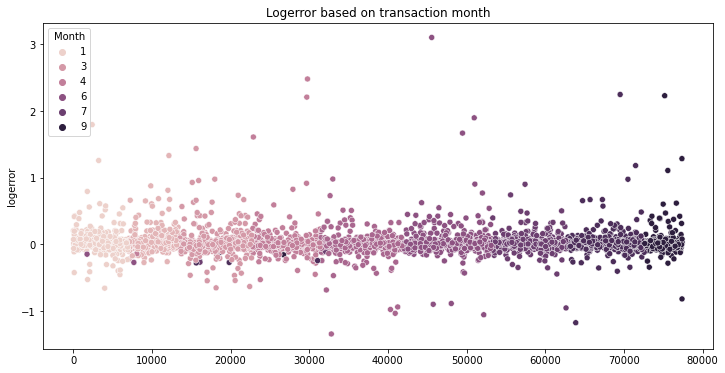

In [6]:
# Transaction_month vs LogError
plt.figure(figsize=(12,6))
sns.scatterplot(x=train.index,y=train.logerror,hue=train.transaction_month).set_title("Logerror based on transaction month")
plt.legend(loc='upper left', title='Month')
plt.show()

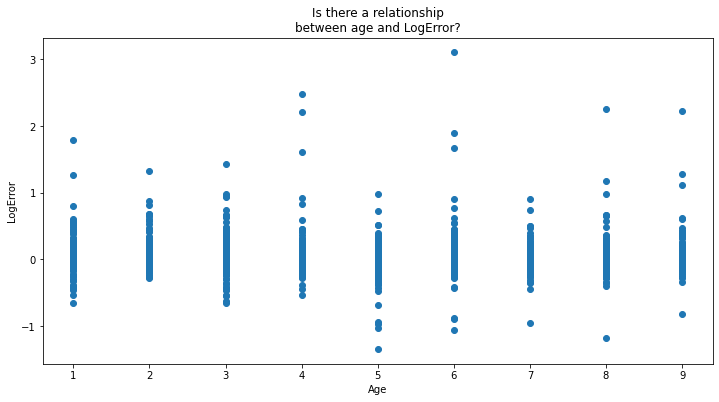

In [7]:
# plot month by logerror
plt.figure(figsize=(12,6))
plt.scatter(train.transaction_month, train.logerror)
plt.xlabel("Age")
plt.ylabel("LogError")
plt.title("Is there a relationship\nbetween age and LogError?")
plt.show()

Text(0.5, 1.0, 'LogError by Month')

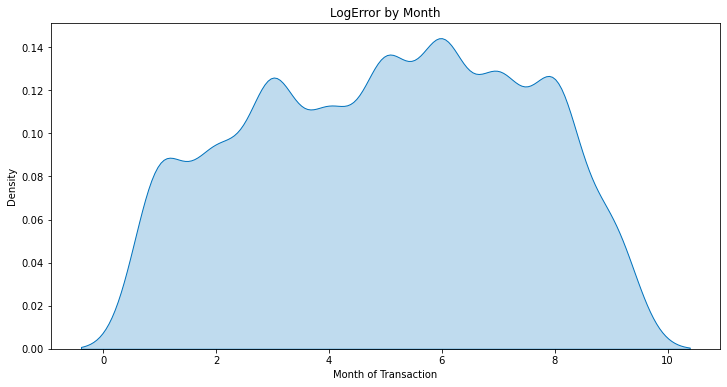

In [8]:
# plot month by logerror
plt.figure(figsize=(12,6))
Mth = sns.kdeplot(train.transaction_month[(train["logerror"] < 1) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('Month of Transaction')
Mth.set_title('LogError by Month')

In [9]:
# import One-sample, t-test
from scipy.stats import ttest_1samp

# Transactions in 06 - June
june_train = train[train.transaction_month == 6]

# Population Average
pop_mean = train.logerror.mean()

alpha = .05

In [10]:
# standard error = sample stddev / sample size
std_error = june_train.logerror.std() / june_train.shape[0]

# t-score = sample mean - population mean / standard error
t = (june_train.logerror.mean() - train.logerror.mean()) / std_error

# degree of freedom = sample size minus 1
degf = june_train.shape[0] - 1

# p-value of t-score
p = stats.t(degf).sf(t)

print('Alpha = .05')
print('Transaction Month One-Sample, One-Tailed T-Test')
print('t-score: ',t)
print('p-value: ',p)
if p > alpha:
    print("We fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis.\n")

Alpha = .05
Transaction Month One-Sample, One-Tailed T-Test
t-score:  15.348327527476451
p-value:  4.091728791931454e-44
We reject null hypothesis.



### Testing Square Feet features With Hypothesis Testing

### calculatedfinishedsquarefeet with Hypothesis Testing
#### Correlation Test
Testing correlation of calculatedfinishedsquarefeet and LogError.

$H_O$: There is no linear correlation between calculatedfinishedsquarefeet and logerror.  
$H_A$: There is a linear correlation between calculatedfinishedsquarefeet and logerror.

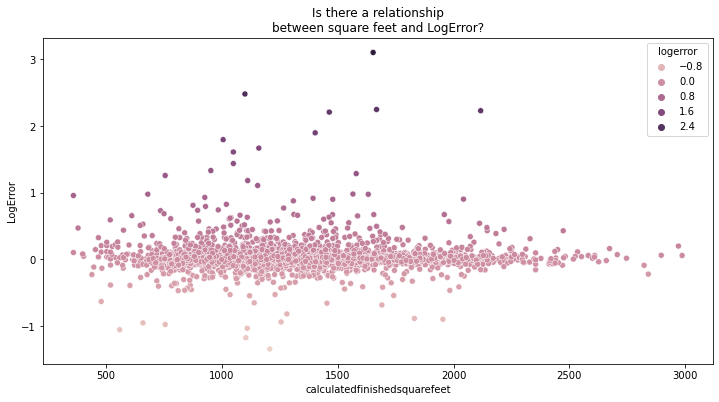

In [11]:
# plots calculatedfinishedsquarefeet
plt.figure(figsize=(12,6))
sns.scatterplot(x=train.calculatedfinishedsquarefeet, y=train.logerror, hue=train.logerror)
plt.xlabel("calculatedfinishedsquarefeet")
plt.ylabel("LogError")
plt.title("Is there a relationship\nbetween square feet and LogError?")
plt.show()

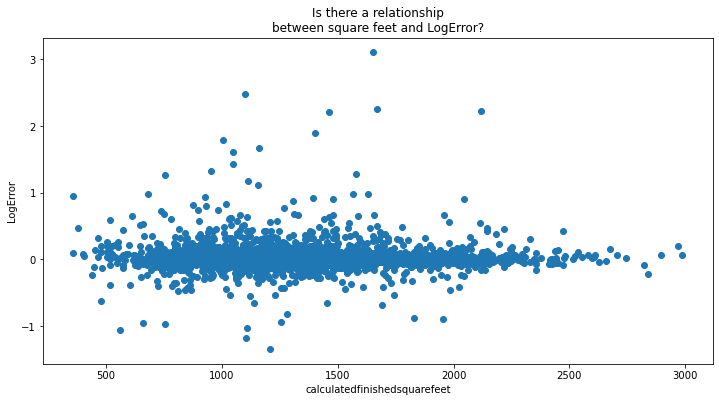

In [12]:
# plot square feet by logerror
plt.figure(figsize=(12,6))
plt.scatter(train.calculatedfinishedsquarefeet, train.logerror)
plt.xlabel("calculatedfinishedsquarefeet")
plt.ylabel("LogError")
plt.title("Is there a relationship\nbetween square feet and LogError?")
plt.show()

Text(0.5, 1.0, 'LogError by Square Feet')

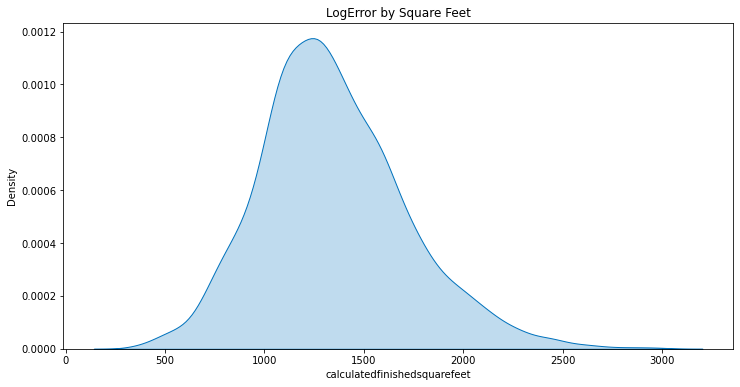

In [13]:
# plot square feet by logerror
plt.figure(figsize=(12,6))
Mth = sns.kdeplot(train.calculatedfinishedsquarefeet[(train["logerror"] < 1) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('calculatedfinishedsquarefeet')
Mth.set_title('LogError by Square Feet')

In [14]:
# p-value must be lower than alpha to reject null hypothesis
alpha = .05
r, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.logerror)
print('Alpha = .05')
print('Correlation Test on calculatedfinishedsquarefeet')
print('p-value: ',p)
print('r-value: ',r)
if p > alpha:
    print("We fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis")
print('Low r-value suggests might have non-linear correlation.\n')

Alpha = .05
Correlation Test on calculatedfinishedsquarefeet
p-value:  0.7018954274756041
r-value:  -0.0064748987357816125
We fail to reject null hypothesis
Low r-value suggests might have non-linear correlation.



## Cluster Exploration

In [15]:
# scales data for cluster exploration
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test)
train_scaled

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_rate,age,transaction_month
31129,-0.259474,-1.187247,-2.485576,-1.445021,-0.449694,-0.054855,-0.420038,-0.797617,-0.459800,-0.405945,-1.047807,-1.921402,-2.159641,-0.867993,-1.482210,-0.460090,-0.247775,1.834212,-0.430538
3021,-0.018493,-1.187247,0.050770,-0.647264,-0.449694,-0.767053,-0.611828,-0.412379,-0.435699,0.316324,-0.754649,-0.921732,0.929734,2.780629,0.194297,-0.435987,-0.274604,-0.282614,-1.696096
7086,-0.043635,0.571619,0.050770,0.042688,-0.449694,-0.763547,-0.154841,-0.612833,-0.441864,-0.205589,-0.583226,-0.235039,-0.847992,-1.057637,0.168984,-0.442153,0.544634,-0.859930,-0.852391
42008,-0.137447,0.571619,0.050770,-0.178312,-0.449694,-0.289169,-0.242034,-0.834358,-0.459317,-0.405945,-1.199355,-1.334169,-1.726051,-0.971707,-1.246603,-0.459607,-0.257236,1.513481,0.413167
55288,0.428942,0.571619,0.050770,-0.151361,0.805630,-2.089479,1.829189,0.273270,0.793905,-0.400376,1.319819,-0.120018,-0.190457,-0.146396,-1.034362,0.793685,-0.696207,-1.244808,0.835020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,-0.452625,-1.187247,0.050770,-0.477471,-0.449694,0.685224,-0.457826,-1.607537,-0.455246,6.147988,-0.071441,0.239825,0.157314,-0.076422,-0.498893,-0.455535,-0.441500,-0.090175,0.835020
76488,-0.295200,0.571619,2.587117,1.330958,-0.449694,-0.066374,-0.931848,0.190063,-0.432720,-0.157922,-0.777008,-0.409291,1.490825,2.987393,1.206821,-0.433008,0.041250,1.000311,1.678725
16607,-0.476513,0.571619,-1.217403,-0.038166,-0.449694,0.590430,-1.076872,-0.362130,-0.465074,-0.405945,-0.096285,-0.022487,0.728622,1.214441,-1.774284,-0.465364,-1.261864,-0.090175,-0.852391
65599,-0.308215,0.571619,0.050770,0.279859,-0.449694,-0.207300,-0.773213,-0.472353,-0.457259,-0.405945,-1.037870,0.015089,1.405824,2.264384,0.799864,-0.457548,-0.117395,-0.154322,1.256873


# Testing Clusters with Hypothesis Testing - ANOVA Test
$H_O$: There is no signficant difference between the logerror means of each cluster group.  
$H_A$: There is a signficant difference between the logerror means of at least two cluster groups.

### ANOVA Test on Tax Cluster

In [16]:
# list of variables I will cluster on.
X = train_scaled[['taxvaluedollarcnt', 'taxamount','tax_rate']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [17]:
train_scaled['cluster_tax'] = kmeans.predict(X)

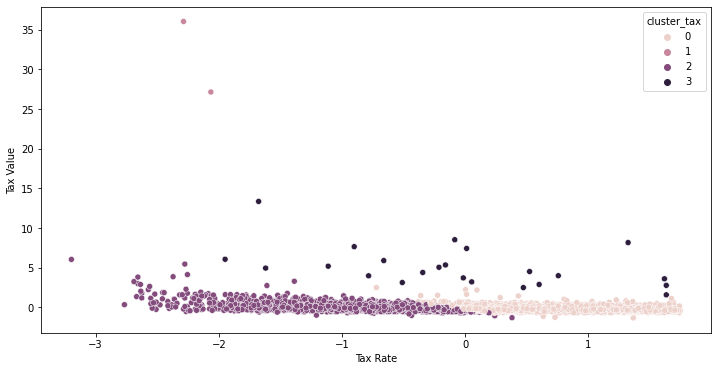

In [18]:
# plot tax rate by log error
plt.figure(figsize=(12,6))
sns.scatterplot(x=train_scaled.taxvaluedollarcnt,y=train_scaled.tax_rate, hue=train_scaled.cluster_tax)
plt.xlabel("Tax Rate")
plt.ylabel("Tax Value")
plt.show()

In [19]:
train, validate, test = prepare.create_clusters(train, validate, test)

alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_tax == 0].logerror,
                      train[train.cluster_tax == 1].logerror,
                      train[train.cluster_tax == 2].logerror,
                      train[train.cluster_tax == 3].logerror)

print('Anova Test Results on Tax Cluster')
print('F-value: ',F)
print('p-value: ',p)
if p > alpha:
    print("\nWe fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis\n\n")

Anova Test Results on Tax Cluster
F-value:  0.7440007452498758
p-value:  0.525749295063882

We fail to reject null hypothesis


### ANOVA Test on squarefeet cluster

In [20]:
X = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(n_clusters=5)

In [21]:
train_scaled['cluster_sqft'] = kmeans.predict(X)

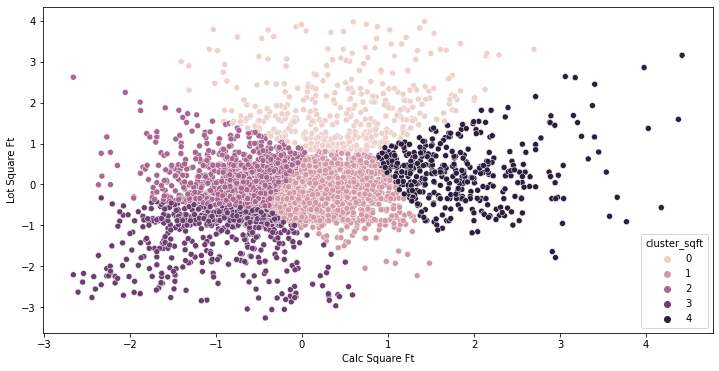

In [22]:
# plot square feet by log error
plt.figure(figsize=(12,6))
sns.scatterplot(x=train_scaled.calculatedfinishedsquarefeet, y=train_scaled.lotsizesquarefeet, hue=train_scaled.cluster_sqft)
plt.xlabel("Calc Square Ft")
plt.ylabel("Lot Square Ft")
plt.show()

In [23]:
alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_sqft == 0].logerror,
                      train[train.cluster_sqft == 1].logerror,
                      train[train.cluster_sqft == 2].logerror,
                      train[train.cluster_sqft == 3].logerror,
                      train[train.cluster_sqft == 4].logerror)

print('Anova Test Results on SQFT Cluster')
print('F-value: ',F)
print('p-value: ',p)
if p > alpha:
    print("\nWe fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis\n\n")

Anova Test Results on SQFT Cluster
F-value:  1.1191728652407233
p-value:  0.34550957036591506

We fail to reject null hypothesis


#### ANOVA Test on Rooms Cluster  

$H_O$: There is no signficant difference between the log error means of each cluster.  
$H_A$: There is a signficant difference between the log error means of at least two clusters.

In [24]:
X = train_scaled[['bedroomcnt','bathroomcnt']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [25]:
train_scaled['cluster_rooms'] = kmeans.predict(X)

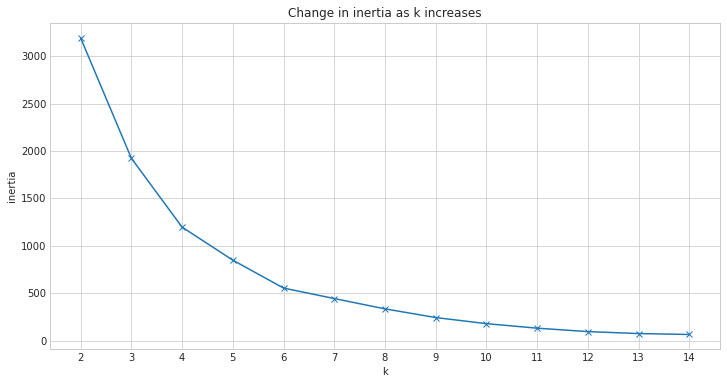

In [26]:
# Find K: evaluate best k using elbow method and analyzing the change in sse
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

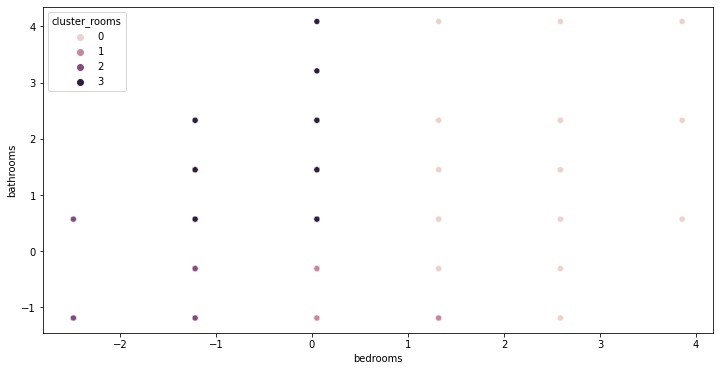

In [27]:
# plot rooms by log error
plt.figure(figsize=(12,6))
sns.scatterplot(x=train_scaled.bedroomcnt, y=train_scaled.bathroomcnt, hue=train_scaled.cluster_rooms)
plt.xlabel("bedrooms")
plt.ylabel("bathrooms")
plt.show()

In [28]:
alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_rooms == 0].logerror,
                      train[train.cluster_rooms == 1].logerror,
                      train[train.cluster_rooms == 2].logerror,
                      train[train.cluster_rooms == 3].logerror)

print('Anova Test Results on Room/Age Cluster')
print('F-value: ',F)
print('p-value: ',p)
if p > alpha:
    print("\nWe fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis\n\n")

Anova Test Results on Room/Age Cluster
F-value:  0.10303872473390041
p-value:  0.9582991466352792

We fail to reject null hypothesis


### Takeaways
#### Explore Takeaways
Independent Features
- Independent features explored did not have linear correlation
- Visualy can see non-linear correlation with transaction month

Clustered Features
- No clusters had significant difference within their groupings
- Used Elbow test to select features, but some groupings still had very little observations - narrow down k
- Further testing with different features is needed to determine if there are significant clusters

# Model

In [29]:
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test)

In [30]:
train_scaled, validate_scaled, test_scaled = prepare.create_clusters(train_scaled, validate_scaled, test_scaled)

### First set baseline

In [31]:
# split into X variables and y target

# X is every column except log_error
X_train = train_scaled
# y is only log error, [[]] to keep as df and not series

y_train = train[['logerror']]

# repeat for validate and test
X_validate = validate_scaled
y_validate = validate[['logerror']]

X_test = test_scaled
y_test = test[['logerror']]

# setting baseline to average log_error
baseline = train.logerror.mean()

# calculating MSE with y_train (actual) and baseline (extended to same size as df)
baseline_mse = mean_squared_error(y_train, np.full(y_train.shape, baseline))
baseline_rmse = baseline_mse**1/2


# Baseline for train data
train["base_logerror"] = train.logerror.mean()
RMSE_base = sqrt(mean_squared_error(train.logerror,train.base_logerror))
print(f'The Baseline train RMSE logerror is :{RMSE_base}')

# Baseline for validate data
validate["base_logerror"] = validate.logerror.mean()
RMSE_validate = sqrt(mean_squared_error(validate.logerror,validate.base_logerror))
R2_validate = r2_score(validate.logerror,validate.base_logerror)
print(f'The baseline validate RMSE =  {RMSE_validate} , R2 = {R2_validate}')

#Baseline for test dataset
test["base_logerror"] = test.logerror.mean()
RMSE_test = sqrt(mean_squared_error(test.logerror,test.base_logerror))
R2_test = r2_score(test.logerror,test.base_logerror)
print(f'The baseline test RMSE =  {RMSE_test} , R2 = {R2_test}')

The Baseline train RMSE logerror is :0.190676973363795
The baseline validate RMSE =  0.18946532550744344 , R2 = 1.1102230246251565e-16
The baseline test RMSE =  0.20811166165565512 , R2 = 0.0


In [32]:
#Predict logerror_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# Compute logerror_logerrorpred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# RMSE of tax_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# RMSE of tax_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** (1/2)
rmse_validate_baseline = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** (1/2)
print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate_baseline)

RMSE using Mean
Train/In-Sample:  0.19067697336379497 
Validate/Out-of-Sample:  0.1895028833826636
RMSE using Median
Train/In-Sample:  0.19167345680705614 
Validate/Out-of-Sample:  0.19089167091273737


In [33]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

## Model 1 - Linear Regression based on all features

In [34]:
#make the thing
lm = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.19023075554397648 
Validation/Out-of-Sample:  0.20377574060901166


In [35]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_ols,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.189503,0.000000
1,OLS Regressor,0.203776,-0.156683


In [36]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train.logerror)
y_hat = lm1.predict(X_train)

y_train['lm_1'] = y_hat

mean_squared_error(y_train.logerror, y_hat)**(1/2)

0.19023075554397648

## Model 2 Linear Regression with select features from Select K Best

### Select K Best to determine features with top Linear Correlation to LogError

In [37]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features to select
rfe = RFE(lm, 9)

# fit the data using RFE
rfe.fit(X_train,y_train.logerror)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

# Features elected by SelectKBest
print('SelectKBest Top 9 Features:')
rfe_feature

SelectKBest Top 9 Features:


['parcelid',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'censustractandblock',
 'tax_rate']

In [38]:
X_train_2 = train_scaled[['rawcensustractandblock','structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt',
                          'censustractandblock','tax_rate']]

lm2 = LinearRegression()
lm2.fit(X_train_2, y_train.logerror)
y_hat = lm2.predict(X_train_2)

y_train['lm_2'] = y_hat

mean_squared_error(y_train.logerror, y_hat)**(1/2)

0.1904000118095429

## Model 3 Polynomial Regression on all features

In [39]:
# make the polynomial features to get a new set of features
pf1 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf1.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf1.transform(X_validate)
X_test_degree =  pf1.transform(X_test)

# create the model object
lmP1 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lmP1.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['poly_1'] = lmP1.predict(X_train_degree2)

# evaluate: rmse
rmse_validate_lmP1 = mean_squared_error(y_train.logerror, y_train.poly_1)**1/2

# predict validate
y_validate['poly_1'] = lmP1.predict(X_validate_degree)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.poly_1) ** (1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.19023075554397648


In [40]:
metric_df = metric_df.append({
    'model': 'Polynomial Regression', 
    'RMSE_validate': rmse_validate_lmP1,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.poly_1)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.189503,0.000000e+00
1,OLS Regressor,0.203776,-1.566826e-01
2,Polynomial Regression,0.006685,-1.005751e+20


## Model 4  Lasso & Lars

In [41]:
# create the model object
lars = LassoLars(alpha=.1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  0.19067697336379497 
Validation/Out-of-Sample:  0.1895028833826636


In [42]:
metric_df = metric_df.append({
    'model': 'LassoLars', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.189503,0.000000e+00
1,OLS Regressor,0.203776,-1.566826e-01
2,Polynomial Regression,0.006685,-1.005751e+20
3,LassoLars,0.189503,0.000000e+00


In [43]:
print("RMSE using Mean\nTrain/In-Sample: ", rmse_train)

RMSE using Mean
Train/In-Sample:  0.19067697336379497


In [44]:
# input for all features
X_test_2 = test_scaled[['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'lotsizesquarefeet',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'tax_rate',
       'age', 'transaction_month', 'cluster_tax', 'cluster_sqft',
       'cluster_rooms']]

X_test_degree2 = pf1.transform(X_test_2)

# predict validate
y_test['poly_1'] = lmP1.predict(X_test_degree2)

# evaluate: rmse
rmse_validate = (mean_squared_error(y_test.logerror, y_test.poly_1))**(1/2)

rmse_validate

8277733.704789434

In [45]:
# predict on test
y_test['poly_1'] = lmP1.predict(X_test_degree)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.poly_1) ** (1/2)

print("RMSE for Model using \nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using 
Out-of-Sample Performance:  8277733.704789434


### Modeling Takeaways

- Linear Regression did not outperform baseline - was more consistent between train and validate.

- Polynomial Model outperformed on train, but did WAAAY worse on validate/test.

- LassoLars was even to baseline - will need to research why?

# Conclusion

- Independent features explored did not have a linear correlation.
- Visualy observed there is non-linear correlation with transaction month.
- No clusters had significant difference within their groupings.
- Linear Regression with Polynomials of 3rd Degree performed better than baseline on train, but not on validate or test.

### If I had more time:
- Further testing with different features is needed to determine if there are significant clusters.